Uploading the CSV an converting it into a dataframe

In [91]:
#import data
import pandas as pd
data = pd.read_csv("stroke-data.csv")

Preprocessing

In [92]:
#dropping id attribute since it is a unique value
data = data.drop("id", axis=1)

#remove rows where bmi=na for patients without stroke
data = data.drop(data[(data.bmi.isna()) & (data.stroke==0)].index)

#creating age bins for imputing
#temporary attribute created for easy bin calculation
data['age_group'] = pd.cut(data['age'],bins=[0, 20, 30, 40, 50, 60, 70, 80, 90],labels=['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81+'])
means = data.groupby('age_group')['bmi'].mean()

#checking means
print("Mean BMI for each age group:")
print(means)

'''
output:
Mean BMI for each age group:
age_group
0-20     22.203600
21-30    28.523507
31-40    31.223457
41-50    31.424162
51-60    31.889268
61-70    30.956738
71-80    29.140520
81+      27.988696
Name: bmi, dtype: float64

'''

#imputing
for age_group in means.index:
    data.loc[(data['age_group'] == age_group) & (data['bmi'].isna()), 'bmi'] = means[age_group]
data = data.drop('age_group', axis=1)


#downsampling to make non-stroke cases 1500
#splitting up dataset
stroke_cases = data[data.stroke==1]
non_stroke_cases = data[data.stroke==0]
non_stroke_cases = non_stroke_cases.sample(n=1500,random_state=42)

#combining datasets
data = pd.concat([stroke_cases,non_stroke_cases])
print(len(data[data.stroke==0])) #1500
print(len(data[data.stroke==1])) #249



Mean BMI for each age group:
age_group
0-20     22.203600
21-30    28.523507
31-40    31.223457
41-50    31.424162
51-60    31.889268
61-70    30.956738
71-80    29.140520
81+      27.988696
Name: bmi, dtype: float64
1500
249


<ipython-input-92-4f86e0957c54>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = data.groupby('age_group')['bmi'].mean()


New Feature Creation

In [93]:
#bmi classification feature
def bmi_classification(bmi):
    if bmi < 18.5:
        return 'Under Weight'
    elif 18.5 <= bmi < 25:
        return 'Normal Weight'
    elif 25 <= bmi < 30:
        return 'Over Weight'
    else:
        return 'Obese'
data['bmi_classification']=data['bmi'].apply(bmi_classification)

#converting categorical attributes into binary
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status','bmi_classification']
data = pd.get_dummies(data, columns=categorical_columns,drop_first=True)


In [94]:
#saving downsampled data set
data.to_csv("downsampled_stroke.csv")
data.head(10)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_classification_Obese,bmi_classification_Over Weight,bmi_classification_Under Weight
0,67.0,0,1,228.69,36.600000,1,True,True,False,True,False,False,True,True,False,False,True,False,False
1,61.0,0,0,202.21,30.956738,1,False,True,False,False,True,False,False,False,True,False,True,False,False
2,80.0,0,1,105.92,32.500000,1,True,True,False,True,False,False,False,False,True,False,True,False,False
3,49.0,0,0,171.23,34.400000,1,False,True,False,True,False,False,True,False,False,True,True,False,False
4,79.0,1,0,174.12,24.000000,1,False,True,False,False,True,False,False,False,True,False,False,False,False
5,81.0,0,0,186.21,29.000000,1,True,True,False,True,False,False,True,True,False,False,False,True,False
6,74.0,1,1,70.09,27.400000,1,True,True,False,True,False,False,False,False,True,False,False,True,False
7,69.0,0,0,94.39,22.800000,1,False,False,False,True,False,False,True,False,True,False,False,False,False
8,59.0,0,0,76.15,31.889268,1,False,True,False,True,False,False,False,False,False,False,True,False,False
9,78.0,0,0,58.57,24.200000,1,False,True,False,True,False,False,True,False,False,False,False,False,False


Visualizations

Text(0.5, 1.0, 'Age vs BMI Scatter Plot')

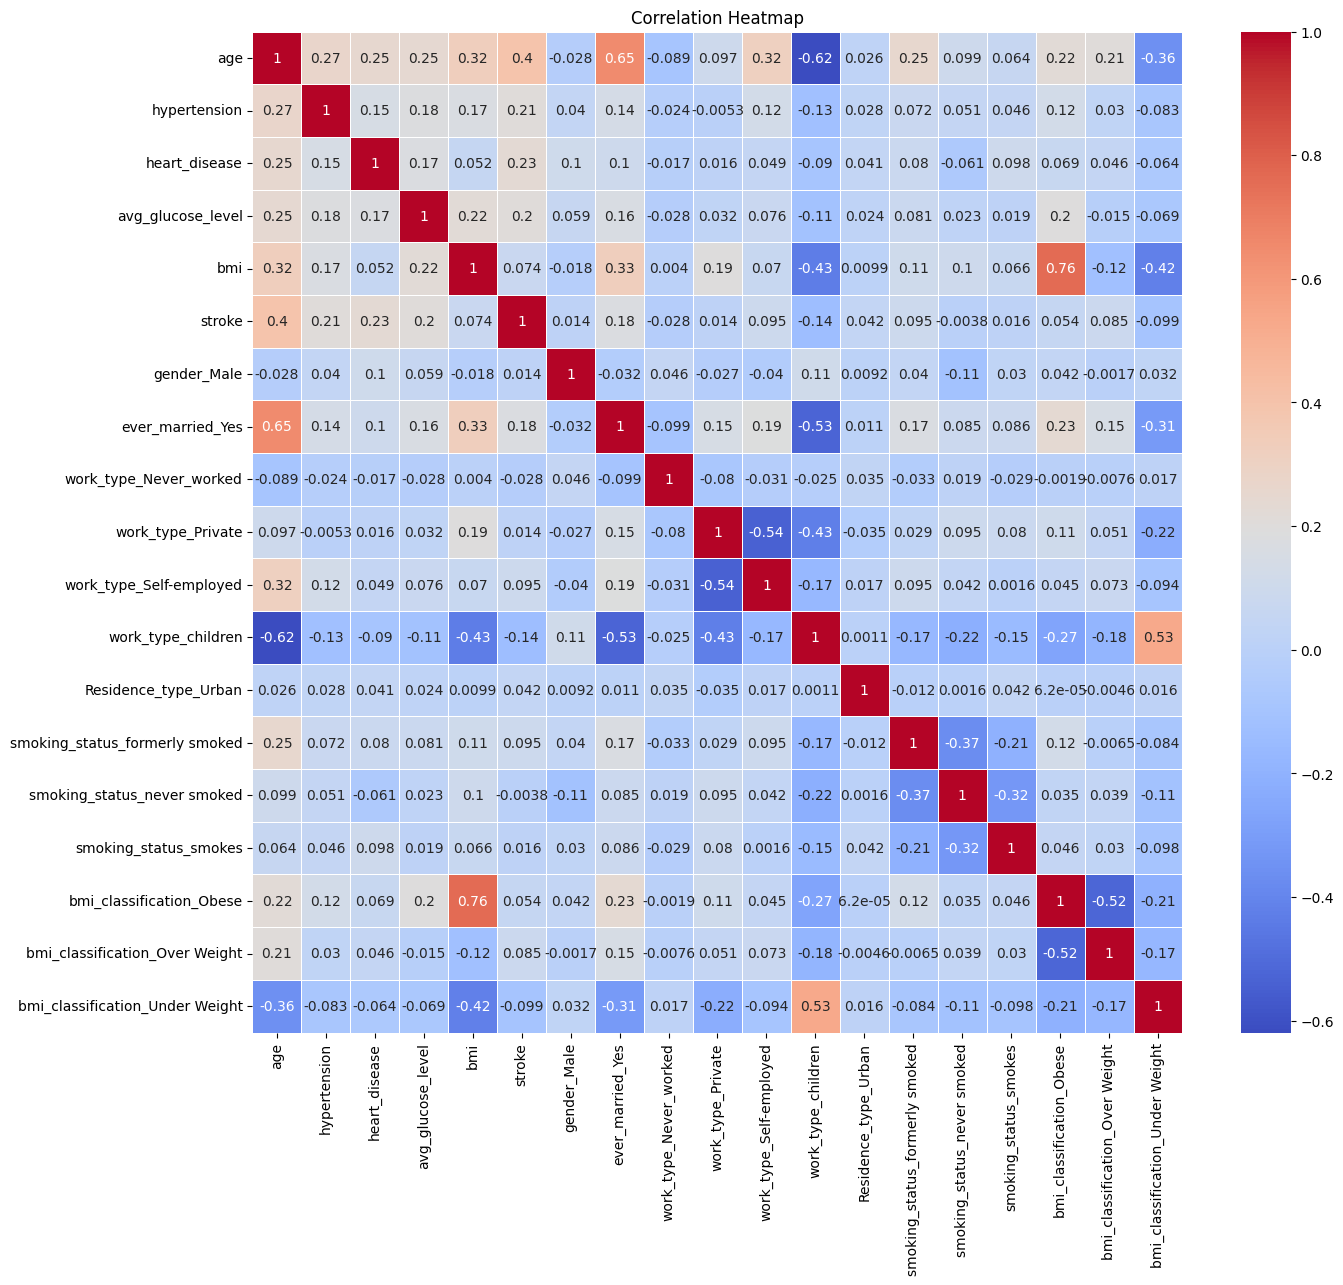

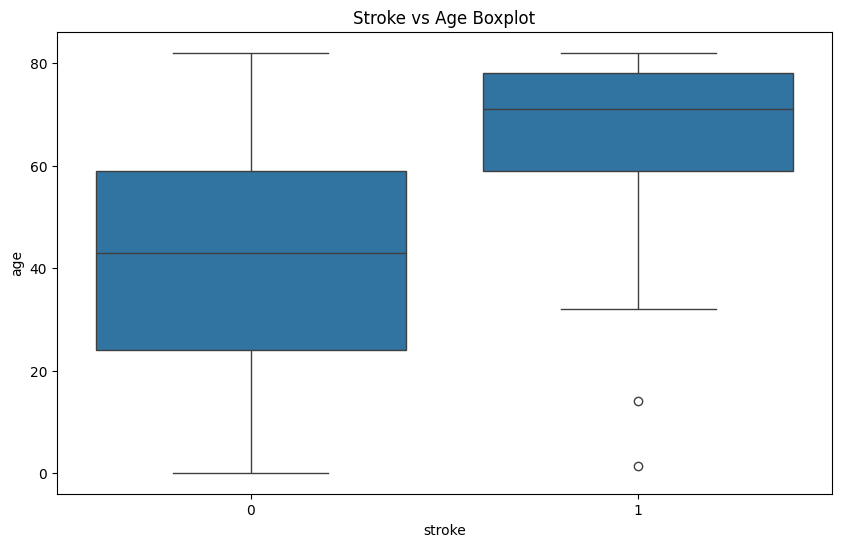

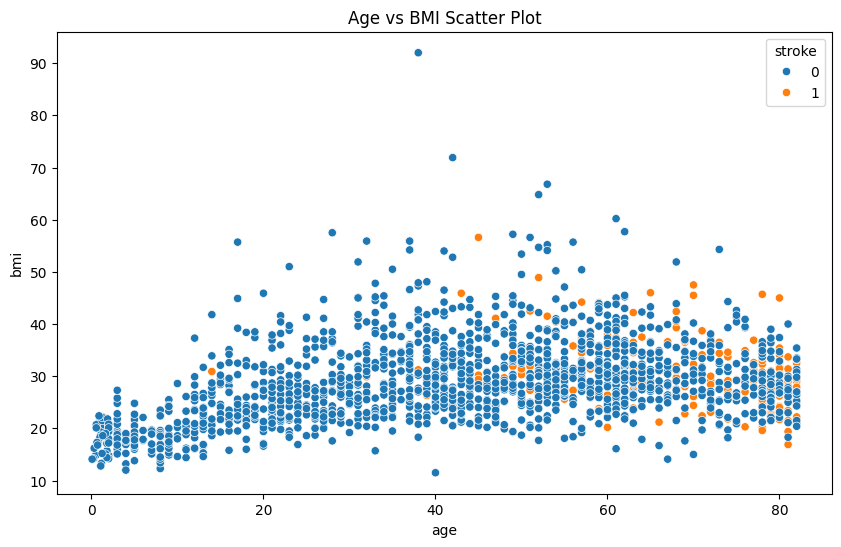

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

#heatmap showing feature correlation
plt.figure(figsize=(15, 13))
sns.heatmap(data.corr('pearson'), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')

#stroke vs age boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='stroke', y='age', data=data)
plt.title('Stroke vs Age Boxplot')

#age vs bmi scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='bmi', hue='stroke', data=data)
plt.title('Age vs BMI Scatter Plot')

Decision Tree classification

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#splitting up data into training and test sets
X=data.drop('stroke',axis=1)
y=data['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)


#using max depth = 5
model_5 = DecisionTreeClassifier(criterion='entropy',max_depth=5)
model_5.fit(X_train, y_train)

predictions_5 = model_5.predict(X_test)

accuracy_5 = accuracy_score(y_test, predictions_5)
print(f"Accuracy: {accuracy_5}")
#Accuracy: 0.8657142857142858

print("Classification Report:")
print(classification_report(y_test, predictions_5))
'''
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       304
           1       0.46      0.13      0.20        46

    accuracy                           0.87       350
   macro avg       0.67      0.55      0.57       350
weighted avg       0.83      0.87      0.83       350

'''

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions_5))
'''
Confusion Matrix:
[[297   7]
 [ 40   6]]

'''



Accuracy: 0.8657142857142858
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       304
           1       0.46      0.13      0.20        46

    accuracy                           0.87       350
   macro avg       0.67      0.55      0.57       350
weighted avg       0.83      0.87      0.83       350

Confusion Matrix:
[[297   7]
 [ 40   6]]


Decision Tree with class weight parameter

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#class weightwhich will help give weight to stroke cases
#obtained from dividing number of non-stroke cases by stroke cases (roughly 6:1 ratio)
class_weight = {0: 1, 1: 6}

#splitting up data
X=data.drop('stroke',axis=1)
y=data['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)


#using max depth = 5
model_5 = DecisionTreeClassifier(criterion='entropy',max_depth=5,class_weight = {0: 1, 1: 6}
)
model_5.fit(X_train, y_train)

predictions_5 = model_5.predict(X_test)

accuracy_5 = accuracy_score(y_test, predictions_5)
print(f"Accuracy: {accuracy_5}")
#Accuracy: 0.7257142857142858

print("Classification Report:")
print(classification_report(y_test, predictions_5))
'''
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       304
           1       0.28      0.70      0.40        46

    accuracy                           0.73       350
   macro avg       0.61      0.71      0.61       350
weighted avg       0.85      0.73      0.77       350

'''

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions_5))

'''
Confusion Matrix:
[[222  82]
 [ 14  32]]

'''


Accuracy: 0.7257142857142858
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       304
           1       0.28      0.70      0.40        46

    accuracy                           0.73       350
   macro avg       0.61      0.71      0.61       350
weighted avg       0.85      0.73      0.77       350

Confusion Matrix:
[[222  82]
 [ 14  32]]


Using stratified k-fold with decision tree to split data and preserve ratio

In [139]:
#using stratified kfold to split data to maintain proportions
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,recall_score,precision_score

#creating stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#class weightwhich will help give weight to stroke cases
#obtained from dividing number of non-stroke cases by stroke cases (roughly 6:1 ratio)
class_weight = {0: 1, 1: 6}

fold = 1

#must be stored in array for the different splits
dt_accuracy=[]
dt_recall=[]
dt_precision=[]

#splitting into training and testing
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt = DecisionTreeClassifier(max_depth=5, class_weight=class_weight, random_state=42)
    dt.fit(X_train, y_train)
    predictions = dt.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    dt_accuracy.append(accuracy)
    recall = recall_score(y_test, predictions)
    dt_recall.append(recall)
    precision = precision_score(y_test, predictions)
    dt_precision.append(precision)

    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    fold += 1

#overall metrics
print("\nOverall Metrics:")
print("Accuracy:", sum(dt_accuracy) / len(dt_accuracy))
print("Recall:", sum(dt_recall) / len(dt_recall))
print("Precision:", sum(dt_precision) / len(dt_precision))

'''
output for five folds :
Accuracy: 0.6628571428571428
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.65      0.77       300
           1       0.26      0.74      0.39        50

    accuracy                           0.66       350
   macro avg       0.60      0.70      0.58       350
weighted avg       0.84      0.66      0.71       350

Confusion Matrix:
[[195 105]
 [ 13  37]]
Accuracy: 0.7257142857142858
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       300
           1       0.31      0.72      0.43        50

    accuracy                           0.73       350
   macro avg       0.62      0.72      0.62       350
weighted avg       0.85      0.73      0.76       350

Confusion Matrix:
[[218  82]
 [ 14  36]]
Accuracy: 0.7371428571428571
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.83       300
           1       0.33      0.82      0.47        50

    accuracy                           0.74       350
   macro avg       0.65      0.77      0.65       350
weighted avg       0.87      0.74      0.77       350

Confusion Matrix:
[[217  83]
 [  9  41]]
Accuracy: 0.7771428571428571
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.86       300
           1       0.37      0.82      0.51        50

    accuracy                           0.78       350
   macro avg       0.67      0.79      0.68       350
weighted avg       0.88      0.78      0.81       350

Confusion Matrix:
[[231  69]
 [  9  41]]
Accuracy: 0.7077363896848138
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.71      0.81       300
           1       0.28      0.67      0.39        49

    accuracy                           0.71       349
   macro avg       0.60      0.69      0.60       349
weighted avg       0.84      0.71      0.75       349

Confusion Matrix:
[[214  86]
 [ 16  33]]

Overall Metrics:
Accuracy: 0.7221187065083913
Recall: 0.7546938775510204
Precision: 0.30926629688634905
'''


Accuracy: 0.6628571428571428
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.65      0.77       300
           1       0.26      0.74      0.39        50

    accuracy                           0.66       350
   macro avg       0.60      0.70      0.58       350
weighted avg       0.84      0.66      0.71       350

Confusion Matrix:
[[195 105]
 [ 13  37]]
Accuracy: 0.7257142857142858
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.73      0.82       300
           1       0.31      0.72      0.43        50

    accuracy                           0.73       350
   macro avg       0.62      0.72      0.62       350
weighted avg       0.85      0.73      0.76       350

Confusion Matrix:
[[218  82]
 [ 14  36]]
Accuracy: 0.7371428571428571
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.83       300

'\noutput for five folds :\n\nAccuracy: 0.6457142857142857\nClassification Report:\n              precision    recall  f1-score   support\n\n           0       0.94      0.63      0.75       300\n           1       0.25      0.76      0.38        50\n\n    accuracy                           0.65       350\n   macro avg       0.60      0.69      0.57       350\nweighted avg       0.84      0.65      0.70       350\n\nConfusion Matrix:\n[[188 112]\n [ 12  38]]\nAccuracy: 0.7485714285714286\nClassification Report:\n              precision    recall  f1-score   support\n\n           0       0.96      0.74      0.83       300\n           1       0.34      0.80      0.48        50\n\n    accuracy                           0.75       350\n   macro avg       0.65      0.77      0.66       350\nweighted avg       0.87      0.75      0.78       350\n\nConfusion Matrix:\n[[222  78]\n [ 10  40]]\nAccuracy: 0.7457142857142857\nClassification Report:\n              precision    recall  f1-score   su

Using standard splitting for Random forest

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_rf= data.drop('stroke',axis=1)
y_rf= data['stroke']

#splitting up data
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, train_size=0.8, test_size=0.2, random_state=42)

#establishing model
rf_model = RandomForestClassifier(max_depth=5,criterion='entropy',random_state=42)
rf_model.fit(X_train, y_train)

#making predictions
predictions = rf_model.predict(X_test)

#accuracy score
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
#Accuracy: 0.8714285714285714

#classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

'''
Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       304
           1       0.67      0.04      0.08        46

    accuracy                           0.87       350
   macro avg       0.77      0.52      0.51       350
weighted avg       0.85      0.87      0.82       350

'''

#confusion martix
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

'''
Confusion Matrix:
[[303   1]
 [ 44   2]]

'''

Accuracy: 0.8714285714285714
Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       304
           1       0.67      0.04      0.08        46

    accuracy                           0.87       350
   macro avg       0.77      0.52      0.51       350
weighted avg       0.85      0.87      0.82       350

Confusion Matrix:
[[303   1]
 [ 44   2]]


Using class weight parameter in RF

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_rf= data.drop('stroke',axis=1)
y_rf= data['stroke']

#class weight
class_weight = {0: 1, 1: 6}

#splitting up data
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, train_size=0.8, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X_rf= data.drop('stroke',axis=1)
y_rf= data['stroke']

#class weight
class_weight = {0: 1, 1: 6}

#splitting up data
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, train_size=0.8, test_size=0.2, random_state=42)

#establishing model
rf_model = RandomForestClassifier(max_depth=5,criterion='entropy',class_weight=class_weight,random_state=42)
rf_model.fit(X_train, y_train)

#making predictions
predictions = rf_model.predict(X_test)

#accuracy score
print(f"Accuracy: {accuracy_score(y_test, predictions)}")
#Accuracy: 0.7171428571428572


#classification report
print("Classification Report:")
print(classification_report(y_test, predictions))
'''
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       304
           1       0.29      0.80      0.43        46

    accuracy                           0.72       350
   macro avg       0.63      0.75      0.62       350
weighted avg       0.87      0.72      0.76       350

'''

#confusion martix
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

'''
Confusion Matrix:
[[214  90]
 [  9  37]]

'''

Accuracy: 0.7171428571428572
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.70      0.81       304
           1       0.29      0.80      0.43        46

    accuracy                           0.72       350
   macro avg       0.63      0.75      0.62       350
weighted avg       0.87      0.72      0.76       350

Confusion Matrix:
[[214  90]
 [  9  37]]


Implementing Random forest with stratifide splitting

In [130]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,recall_score,precision_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#saving scores of each fold into array
rf_accuracy=[]
rf_recall=[]
rf_precision=[]
fold=1

#splitting data
for train_index, test_index in skf.split(X_rf, y_rf):
    X_train, X_test = X_rf.iloc[train_index], X_rf.iloc[test_index]
    y_train, y_test = y_rf.iloc[train_index], y_rf.iloc[test_index]
    rf = RandomForestClassifier(max_depth=5, class_weight=class_weight, random_state=42)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    rf_accuracy.append(accuracy)
    recall = recall_score(y_test, predictions)
    rf_recall.append(recall)
    precision = precision_score(y_test, predictions)
    rf_precision.append(precision)

    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    fold += 1

print("\nOverall Metrics:")
print("Accuracy:", sum(rf_accuracy) / len(rf_accuracy))
print("Recall:", sum(rf_recall) / len(rf_recall))
print("Precision:", sum(rf_precision) / len(rf_precision))

'''
Accuracy: 0.6914285714285714
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79       300
           1       0.29      0.78      0.42        50

    accuracy                           0.69       350
   macro avg       0.62      0.73      0.60       350
weighted avg       0.85      0.69      0.74       350

Confusion Matrix:
[[203  97]
 [ 11  39]]
Accuracy: 0.7685714285714286
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.85       300
           1       0.37      0.86      0.51        50

    accuracy                           0.77       350
   macro avg       0.67      0.81      0.68       350
weighted avg       0.88      0.77      0.80       350

Confusion Matrix:
[[226  74]
 [  7  43]]
Accuracy: 0.8085714285714286
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       300
           1       0.41      0.82      0.55        50

    accuracy                           0.81       350
   macro avg       0.69      0.81      0.71       350
weighted avg       0.89      0.81      0.83       350

Confusion Matrix:
[[242  58]
 [  9  41]]
Accuracy: 0.7714285714285715
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       300
           1       0.37      0.82      0.51        50

    accuracy                           0.77       350
   macro avg       0.66      0.79      0.68       350
weighted avg       0.88      0.77      0.80       350

Confusion Matrix:
[[229  71]
 [  9  41]]
Accuracy: 0.7220630372492837
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82       300
           1       0.29      0.67      0.40        49

    accuracy                           0.72       349
   macro avg       0.61      0.70      0.61       349
weighted avg       0.84      0.72      0.76       349

Confusion Matrix:
[[219  81]
 [ 16  33]]

Overall Metrics:
Accuracy: 0.7524126074498567
Recall: 0.7906938775510204
Precision: 0.34479452006541794

'''


Accuracy: 0.6914285714285714
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79       300
           1       0.29      0.78      0.42        50

    accuracy                           0.69       350
   macro avg       0.62      0.73      0.60       350
weighted avg       0.85      0.69      0.74       350

Confusion Matrix:
[[203  97]
 [ 11  39]]
Accuracy: 0.7685714285714286
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.85       300
           1       0.37      0.86      0.51        50

    accuracy                           0.77       350
   macro avg       0.67      0.81      0.68       350
weighted avg       0.88      0.77      0.80       350

Confusion Matrix:
[[226  74]
 [  7  43]]
Accuracy: 0.8085714285714286
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       300